In [1]:
# Import libraries

from numpy.random import seed
seed(1)
from tensorflow.python.framework.random_seed import set_random_seed
set_random_seed(1)

import pandas as pd
import numpy  as np
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow import keras
from keras.metrics import SparseCategoricalAccuracy
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from keras import backend as K
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
import keras_tuner as kt



## Pre-processing data

In [2]:
# Merge sensor data with labels

labels = pd.read_csv("features_labels/labels_merged.csv") # Arousal and valence labels (binary)
acc_original = pd.read_csv("features/acc_features.csv").drop(columns=(["Accelerometer_Day","Accelerometer_Hour"]))
hr_original = pd.read_csv("features/hr_features.csv").drop(columns=(["HR_Day","HR_Hour"]))

# # Standardizing label name i.e, 9 becomes 09
splits = labels['Name'].str.split("_")
name = splits.str[0:2].str.join("_")
day = splits.str[2:5].str.join("_")
hour = splits.str[5].str.zfill(2)
labels['Name'] = name + "_" + day + "_" + hour

sensor_merge = acc_original.merge(hr_original,on="Name")

#After merging labels: dataframe drops to 552 samples from 668 
sensor_merge_arousal = sensor_merge.merge(labels[["Name","Arousal_binary"]], left_on="Name", right_on="Name")
sensor_merge_valence = sensor_merge.merge(labels[["Name","Valence_binary"]], left_on="Name", right_on="Name")

In [3]:
# Removing participants with 100% imbalance in arousal

sensor_merge_arousal['PID'] = sensor_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    sensor_merge_arousal = sensor_merge_arousal[sensor_merge_arousal.PID != pid]
    
# Define groups
sensor_merge_arousal['ID'] = sensor_merge_arousal['Name'].str[2:5]
sensor_merge_arousal_groups = sensor_merge_arousal['ID']

In [4]:
# Removing participants with 100% imbalance in valence

sensor_merge_valence['PID'] = sensor_merge_valence['Name'].str[:5]

list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    sensor_merge_valence = sensor_merge_valence[sensor_merge_valence.PID != pid]

# Define groups    
sensor_merge_valence['ID'] = sensor_merge_valence['Name'].str[2:5]
sensor_merge_valence_groups = sensor_merge_valence['ID']

In [5]:
# Shapes to check if merge done properly and samples left after removing participants in each emotion dimension

print(hr_original.shape)
print(acc_original.shape)
print(sensor_merge.shape)
print(sensor_merge_arousal.shape)
print(sensor_merge_valence.shape)

(380, 11)
(380, 11)
(380, 21)
(293, 24)
(195, 24)


## Applying simple ML and DNN

### Early fusion: Arousal

In [29]:
# # Splitting in X and y and validation

# smA_x_all = sensor_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
# smA_y_all = sensor_merge_arousal["Arousal_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=4, random_state=6, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(smA_x_all, smA_y_all, sensor_merge_arousal_groups)):
#     if folds == 1: 
#         smA_x = smA_x_all.iloc[train_idxs]
#         smA_y = smA_y_all.iloc[train_idxs]
#         smA_x_val = smA_x_all.iloc[test_idxs]
#         smA_y_val = smA_y_all.iloc[test_idxs]
        
#         train_test_groups_arousal = sensor_merge_arousal_groups.iloc[train_idxs]
#         val_groups_arousal = sensor_merge_arousal_groups.iloc[test_idxs]
        
#         train_test_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.iloc[train_idxs])
#         val_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.iloc[test_idxs])
        
# print(smA_x.shape)
# print(smA_x_val.shape)
# print("Train test groups: ", train_test_groups_arousal_unique)
# print("Validation groups: ", val_groups_arousal_unique)

In [6]:
# Splitting in X and y and validation

smA_x_all = sensor_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
smA_y_all = sensor_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['ID'].isin(["001", "006","010"])].index

# Get stratified split to make validation set
smA_x = smA_x_all.loc[train_idxs]
smA_y = smA_y_all.loc[train_idxs]
smA_x_val = smA_x_all.loc[test_idxs]
smA_y_val = smA_y_all.loc[test_idxs]

train_test_groups_arousal = sensor_merge_arousal_groups.loc[train_idxs]
val_groups_arousal = sensor_merge_arousal_groups.loc[test_idxs]

train_test_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.loc[train_idxs])
val_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.loc[test_idxs])
        
print(smA_x.shape)
print(smA_x_val.shape)
print("Train test groups: ", train_test_groups_arousal_unique)
print("Validation groups: ", val_groups_arousal_unique)

(235, 20)
(58, 20)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [13]:
# uar_average = []

# cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(smA_x, smA_y, train_test_groups_arousal)):
    
#     X_train = smA_x.iloc[train_idxs]
#     y_train = smA_y.iloc[train_idxs]
#     X_test = smA_x.iloc[test_idxs]
#     y_test = smA_y.iloc[test_idxs]

#     # StandardScaler
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Fitting SVM training
#     svm = SVC()
#     svm.fit(X_train_scaled, y_train),
#     y_pred = svm.predict(X_test_scaled)

#     uar = balanced_accuracy_score(y_test,y_pred)
#     uar_average.append(uar)

# print("SVM test score avg arousal (5 folds)", np.mean(uar_average), "(std: "+str(np.std(uar_average))+")")

In [7]:
# Hyperparameter tuning

start_time = time.time()
# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(smA_x, smA_y, groups=train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

end_time = time.time()
print("Time taken: ", end_time - start_time)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.605321074572112
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'sigmoid'}
Time taken:  4.977699518203735


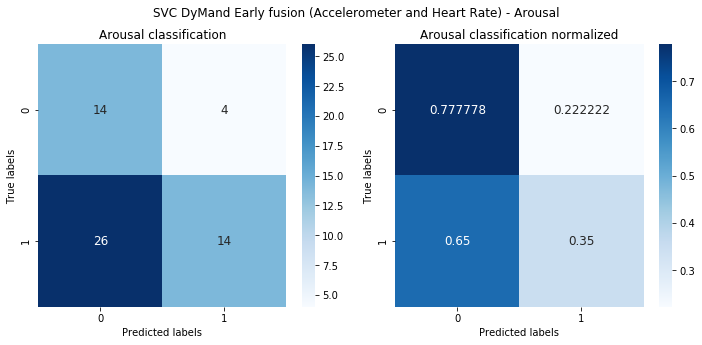

SVM validation Arousal score with best hyperparameters: 0.5638888888888889


In [83]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smA_x
y_train = smA_y
X_test = smA_x_val
y_test = smA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Early fusion (Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters:", uar)

In [12]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=4, random_state=1, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smA_x, smA_y, train_test_groups_arousal)):
    if folds == 1: 
        smA_x_train = smA_x_all.iloc[train_idxs]
        smA_y_train = smA_y_all.iloc[train_idxs]
        smA_x_test = smA_x_all.iloc[test_idxs]
        smA_y_test = smA_y_all.iloc[test_idxs]
        
        smA_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        smA_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", smA_x_train_groups)
print("Testing groups: ", smA_x_test_groups)

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [20]:
def UAR_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
    return uar

In [13]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=20, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_SensorMerge',
                     project_name='Trial9Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(smA_x_train, smA_y_train, epochs=100, validation_data=(smA_x_test, smA_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6655061841011047
Total elapsed time: 00h 02m 11s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 192 
 Second layer: 272 
 Third layer: 272 
 
 Dropout 1: 0.0 
 Dropout 2: 0.0 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 0.001.



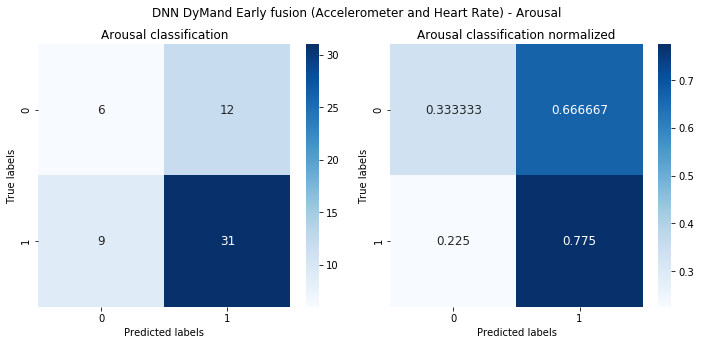

DNN validation score arousal with best hyperparameters 0.5541666666666667


In [82]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smA_x
y_train = smA_y
X_test = smA_x_val
y_test = smA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(192, input_dim=20, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(272, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(272, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Early fusion (Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters", uar)

In [27]:
## Transfer learning 

sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 1e-05

# StandardScaler
smAscaler = StandardScaler()
smA_x_scaled = smAscaler.fit_transform(smA_x)
smA_x_scaled_val = smAscaler.transform(smA_x_val)

#Freezing no layers
# for i in range(7):
#     sensor_merge_TL_model_arousal.layers[i].trainable = True

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    sensor_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    sensor_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    sensor_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    sensor_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning after freezing 0 layers 0.5
Transfer learning after freezing 1 layer 0.5
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.4958333333333333
Transfer learning after freezing 4 layers 0.523611111111111


Transfer learning after freezing 4 layers 0.523611111111111


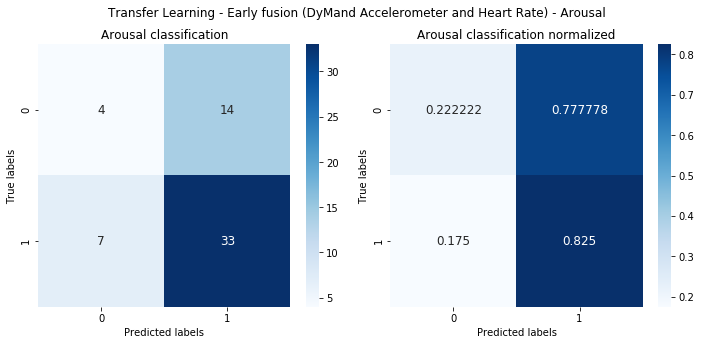

In [35]:
# Freezing layers first 4 layers (including dropout)
sensor_merge_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    sensor_merge_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_arousal.summary()
sensor_merge_TL_model_arousal.fit(smA_x_scaled, smA_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_arousal.predict(smA_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smA_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

# Plotting the confusion matrix
cm = confusion_matrix(smA_y_val,y_pred)
cm_normalized = confusion_matrix(smA_y_val,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Early fusion (DyMand Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Early fusion: Valence


In [71]:
# # Splitting in X and y and validation

# smV_x_all = sensor_merge_valence.drop(columns=(["Name","Valence_binary","PID","ID"]))
# smV_y_all = sensor_merge_valence["Valence_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=5, random_state=16, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(smV_x_all, smV_y_all, sensor_merge_valence_groups)):
#     if folds == 1: 
#         smV_x = smV_x_all.iloc[train_idxs]
#         smV_y = smV_y_all.iloc[train_idxs]
#         smV_x_val = smV_x_all.iloc[test_idxs]
#         smV_y_val = smV_y_all.iloc[test_idxs]
        
#         train_test_groups_valence = sensor_merge_valence_groups.iloc[train_idxs]
#         val_groups_valence = sensor_merge_valence_groups.iloc[test_idxs]
        
#         train_test_groups_valence_unique = np.unique(sensor_merge_valence_groups.iloc[train_idxs])
#         val_groups_valence_unique = np.unique(sensor_merge_valence_groups.iloc[test_idxs])
        
# print(smV_x.shape)
# print(smV_x_val.shape)
# print("Train test groups: ", train_test_groups_valence_unique)
# print("Validation groups: ", val_groups_valence_unique)

In [31]:
# Splitting in X and y and validation

smV_x_all = sensor_merge_valence.drop(columns=(["Name","Valence_binary","PID","ID"]))
smV_y_all = sensor_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = sensor_merge_valence.loc[~sensor_merge_valence['ID'].isin(["004", "009"])].index.to_list()
test_idxs = sensor_merge_valence.loc[sensor_merge_valence['ID'].isin(["004", "009"])].index

# Get stratified split to make validation set
smV_x = smV_x_all.loc[train_idxs]
smV_y = smV_y_all.loc[train_idxs]
smV_x_val = smV_x_all.loc[test_idxs]
smV_y_val = smV_y_all.loc[test_idxs]

train_test_groups_valence = sensor_merge_valence_groups.loc[train_idxs]
val_groups_valence = sensor_merge_valence_groups.loc[test_idxs]

train_test_groups_valence_unique = np.unique(sensor_merge_valence_groups.loc[train_idxs])
val_groups_valence_unique = np.unique(sensor_merge_valence_groups.loc[test_idxs])
        
print(smV_x.shape)
print(smV_x_val.shape)
print("Train test groups: ", train_test_groups_valence_unique)
print("Validation groups: ", val_groups_valence_unique)

(133, 20)
(62, 20)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [18]:
# Hyperparameter tuning

start_time = time.time()
# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(smV_x, smV_y, groups=train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

end_time = time.time()
print("Time taken: ", end_time - start_time)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.6173809523809524
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'sigmoid'}
Time taken:  3.923262357711792


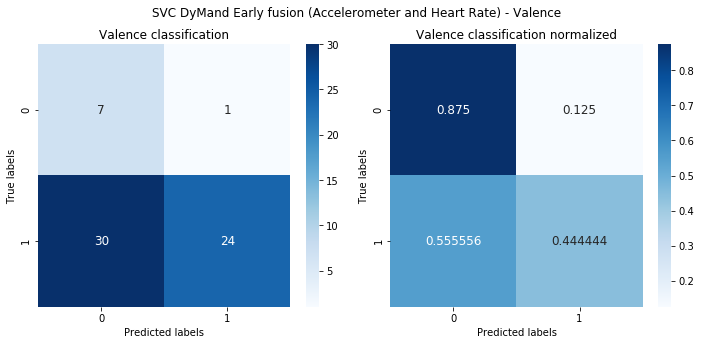

SVM validation score valence with best hyperparameters: 0.6597222222222222


In [81]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smV_x
y_train = smV_y
X_test = smV_x_val
y_test = smV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Early fusion (Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters:", uar)

In [76]:
# ## Deep learning

# def UAR_metric(y_true, y_pred):
#     tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
#     fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
#     fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
#     uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
#     return uar

# uar_average = []
# cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(smV_x, smV_y, train_test_groups_valence)):
    
#     #if folds == 1:
    
#     X_train = smV_x.iloc[train_idxs]
#     y_train = smV_y.iloc[train_idxs]
#     X_test = smV_x.iloc[test_idxs]
#     y_test = smV_y.iloc[test_idxs]

#     # StandardScaler
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Fitting DNN
#     model = Sequential()
#     model.add(Dense(200, input_dim=20, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(100, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     uar_average.append(uar)
    
# print("DNN test score avg valence (5 folds)", np.mean(uar_average), "(std: "+str(np.std(uar_average))+")")

In [20]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(smV_x, smV_y, train_test_groups_valence)):
    if folds == 1: 
        smV_x_train = smV_x_all.iloc[train_idxs]
        smV_y_train = smV_y_all.iloc[train_idxs]
        smV_x_test = smV_x_all.iloc[test_idxs]
        smV_y_test = smV_y_all.iloc[test_idxs]
        
        smV_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        smV_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", smV_x_train_groups)
print("Testing groups: ", smV_x_test_groups)

Training groups:  ['003' '006' '007' '008' '012']
Testing groups:  ['010']


In [65]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=20, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_SensorMerge',
                     project_name='Trial2Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(smV_x_train, smV_y_train, epochs=100, validation_data=(smV_x_test, smV_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6842105388641357
Total elapsed time: 00h 02m 08s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 96 
 Second layer: 160 
 Third layer: 304 
 
 Dropout 1: 0.0 
 Dropout 2: 0.2 
 Dropout 3: 0.3 
 and the optimal learning rate for the optimizer
is 1e-05.



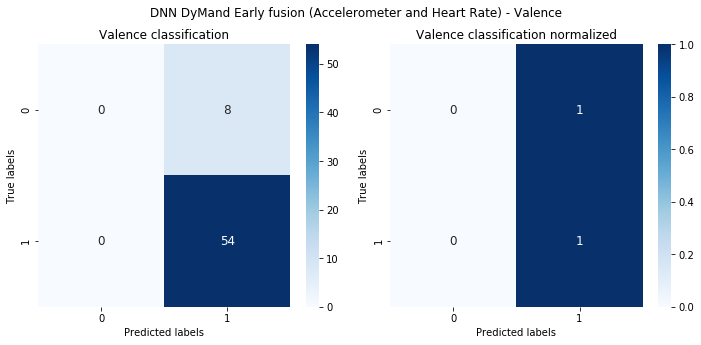

DNN validation score with best hyperparameters for valence: 0.5


In [80]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = smV_x
y_train = smV_y
X_test = smV_x_val
y_test = smV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(256, input_dim=20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(304, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(304, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Early fusion (Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("DNN validation score with best hyperparameters for valence:", uar)

In [33]:
## Transfer learning 

sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.001

# StandardScaler
scaler = StandardScaler()
smV_x_scaled = scaler.fit_transform(smV_x)
smV_x_scaled_val = scaler.transform(smV_x_val)

# Freezing no layers
# for i in range(7):
#     sensor_merge_TL_model_valence.layers[i].trainable = True

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(2):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(4):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

print()

# Freezing layers first layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(1):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing only layer 1", uar)

# Freezing layers second layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(2,3,1):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing only layer 2", uar)

# Freezing layers third layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(4,5,1):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing only layer 3", uar)

# Freezing layers third layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

sensor_merge_TL_model_valence.layers[6].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing only layer 4", uar)

Transfer learning after freezing 0 layers 0.5625
Transfer learning after freezing 1 layer 0.5625
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.5

Transfer learning after freezing only layer 1 0.5625
Transfer learning after freezing only layer 2 0.5625
Transfer learning after freezing only layer 3 0.49074074074074076
Transfer learning after freezing only layer 4 0.5532407407407407


Transfer learning after freezing only layer 1 0.5625


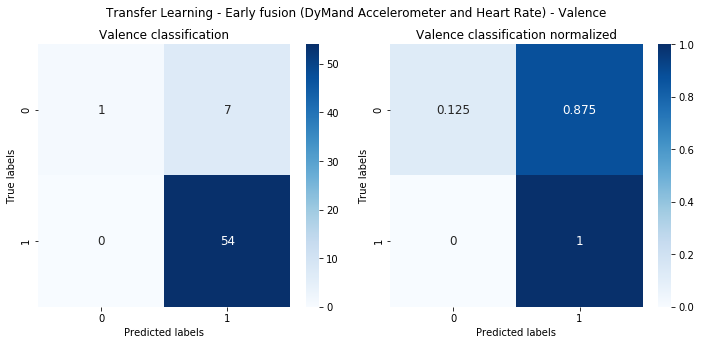

In [34]:
# Freezing layers first layer (including dropout)
sensor_merge_TL_model_valence = load_model("../K-EmoCon/KEmoCon_sensor_earlyfusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
for i in range(1):
    sensor_merge_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
sensor_merge_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# sensor_merge_TL_model_valence.summary()
sensor_merge_TL_model_valence.fit(smV_x_scaled, smV_y, epochs = 100, verbose=0)
# Prediction
y_pred = sensor_merge_TL_model_valence.predict(smV_x_scaled_val, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(smV_y_val, y_pred)
print("Transfer learning after freezing only layer 1", uar)

# Plotting the confusion matrix
cm = confusion_matrix(smV_y_val,y_pred)
cm_normalized = confusion_matrix(smV_y_val,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Early fusion (DyMand Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Late Fusion pre-processing

In [8]:
hr_unimodal_features = hr_original.copy()
acc_unimodal_features = acc_original.copy()

hr_unimodal_labels_merge_arousal = hr_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")
acc_unimodal_labels_merge_arousal = acc_unimodal_features.merge(labels[["Name","Arousal_binary"]], on="Name")

hr_unimodal_labels_merge_valence = hr_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")
acc_unimodal_labels_merge_valence = acc_unimodal_features.merge(labels[["Name","Valence_binary"]], on="Name")

In [9]:
print(hr_unimodal_labels_merge_arousal.shape)
print(acc_unimodal_labels_merge_arousal.shape)
print(hr_unimodal_labels_merge_valence.shape)
print(acc_unimodal_labels_merge_valence.shape)

(380, 12)
(380, 12)
(380, 12)
(380, 12)


In [10]:
# Removing participants with 100% imbalance in arousal

# Heart rate arousal
hr_unimodal_labels_merge_arousal['PID'] = hr_unimodal_labels_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    hr_unimodal_labels_merge_arousal = hr_unimodal_labels_merge_arousal[hr_unimodal_labels_merge_arousal.PID != pid]
# Define groups    
# hr_arousal_groups = hr_unimodal_labels_merge_arousal['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)

# Define groups
hr_unimodal_labels_merge_arousal['ID'] = hr_unimodal_labels_merge_arousal['Name'].str[2:5]
hr_arousal_groups = hr_unimodal_labels_merge_arousal['ID']#.reset_index(drop=True)


# ACC arousal
acc_unimodal_labels_merge_arousal['PID'] = acc_unimodal_labels_merge_arousal['Name'].str[:5]
list_of_remove_participants_arousal = ['P_011','Z_001','Z_007','Z_008','Z_010','Z_011']
for pid in list_of_remove_participants_arousal:
    acc_unimodal_labels_merge_arousal = acc_unimodal_labels_merge_arousal[acc_unimodal_labels_merge_arousal.PID != pid]# Define groups    
# acc_arousal_groups = acc_unimodal_labels_merge_arousal['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)

# Define groups
acc_unimodal_labels_merge_arousal['ID'] = acc_unimodal_labels_merge_arousal['Name'].str[2:5]
acc_arousal_groups = acc_unimodal_labels_merge_arousal['ID']#.reset_index(drop=True)

In [11]:
# Removing participants with 100% imbalance in valence

# Heart rate valence
hr_unimodal_labels_merge_valence['PID'] = hr_unimodal_labels_merge_valence['Name'].str[:5]
list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    hr_unimodal_labels_merge_valence = hr_unimodal_labels_merge_valence[hr_unimodal_labels_merge_valence.PID != pid]
# Define groups    
# hr_valence_groups = hr_unimodal_labels_merge_valence['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)

# Define groups
hr_unimodal_labels_merge_valence['ID'] = hr_unimodal_labels_merge_valence['Name'].str[2:5]
hr_valence_groups = hr_unimodal_labels_merge_valence['ID']#.reset_index(drop=True)



# ACC valence
acc_unimodal_labels_merge_valence['PID'] = acc_unimodal_labels_merge_valence['Name'].str[:5]
list_of_remove_participants_valence = ['P_001','P_003','P_004','P_005','P_006','P_011','P_013','Z_001','Z_005','Z_007','Z_008', 'Z_010', 'Z_011', 'Z_012', 'Z_013']
for pid in list_of_remove_participants_valence:
    acc_unimodal_labels_merge_valence = acc_unimodal_labels_merge_valence[acc_unimodal_labels_merge_valence.PID != pid]
# Define groups    
# acc_valence_groups = acc_unimodal_labels_merge_valence['PID'].str.split("_").str[:2].str.join("").reset_index(drop=True)
# Define groups
acc_unimodal_labels_merge_valence['ID'] = acc_unimodal_labels_merge_valence['Name'].str[2:5]
acc_valence_groups = acc_unimodal_labels_merge_valence['ID']#.reset_index(drop=True)

In [12]:
# Checking if correct number of samples are there after removal of participant imbalance data

print(hr_unimodal_labels_merge_arousal.shape)
print(acc_unimodal_labels_merge_arousal.shape)
print(hr_unimodal_labels_merge_valence.shape)
print(acc_unimodal_labels_merge_valence.shape)

(293, 14)
(293, 14)
(195, 14)
(195, 14)


### Late Fusion: Arousal -- HR

In [90]:
# # Splitting in X and y and validation

# smA_x_all = sensor_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
# smA_y_all = sensor_merge_arousal["Arousal_binary"]

# # Giving the same training and validation groups as in early fusion for arousal audio lexical
# train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
# test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['ID'].isin(["001", "006","010"])].index

# # Get stratified split to make validation set
# smA_x = smA_x_all.loc[train_idxs]
# smA_y = smA_y_all.loc[train_idxs]
# smA_x_val = smA_x_all.loc[test_idxs]
# smA_y_val = smA_y_all.loc[test_idxs]

# train_test_groups_arousal = sensor_merge_arousal_groups.loc[train_idxs]
# val_groups_arousal = sensor_merge_arousal_groups.loc[test_idxs]

# train_test_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.loc[train_idxs])
# val_groups_arousal_unique = np.unique(sensor_merge_arousal_groups.loc[test_idxs])
        
# print(smA_x.shape)
# print(smA_x_val.shape)
# print("Train test groups: ", train_test_groups_arousal_unique)
# print("Validation groups: ", val_groups_arousal_unique)

In [13]:
hr_arousal_x_all = hr_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
hr_arousal_y_all = hr_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['ID'].isin(["001", "006","010"])].index

hr_arousal_x = hr_arousal_x_all.loc[train_idxs]
hr_arousal_y = hr_arousal_y_all.loc[train_idxs]
hr_arousal_x_val = hr_arousal_x_all.loc[test_idxs]
hr_arousal_y_val = hr_arousal_y_all.loc[test_idxs]

hr_train_test_groups_arousal = hr_arousal_groups.loc[train_idxs]
hr_val_groups_arousal = hr_arousal_groups.loc[test_idxs]

hr_train_test_groups_arousal_unique = np.unique(hr_arousal_groups.loc[train_idxs])
hr_val_groups_arousal_unique = np.unique(hr_arousal_groups.loc[test_idxs])
        
print(hr_arousal_x.shape)
print(hr_arousal_x_val.shape)
print("Train test groups: ", hr_train_test_groups_arousal_unique)
print("Validation groups: ", hr_val_groups_arousal_unique)

(235, 10)
(58, 10)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [14]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(hr_arousal_x, hr_arousal_y, groups=hr_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.557341210600548
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 4, 'kernel': 'poly'}


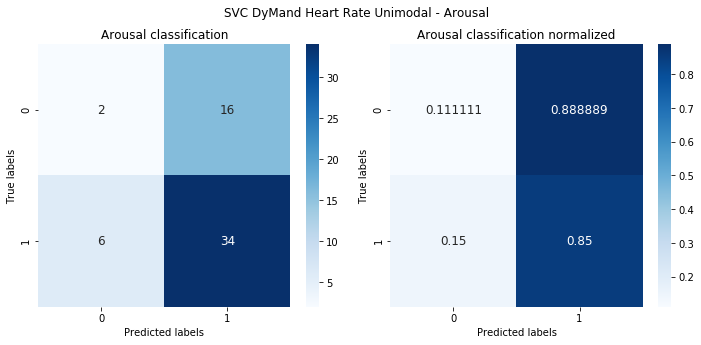

SVM validation Arousal score with best hyperparameters - Heart rate Unimodal: 0.4805555555555555


In [77]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_arousal_x
y_train = hr_arousal_y
X_test = hr_arousal_x_val
y_test = hr_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=4, kernel="poly")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Heart Rate Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Heart rate Unimodal:", uar)

In [18]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=4, random_state=1, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(hr_arousal_x, hr_arousal_y, train_test_groups_arousal)):
    if folds == 1: 
        hr_arousal_x_train = hr_arousal_x_all.iloc[train_idxs]
        hr_arousal_y_train = hr_arousal_y_all.iloc[train_idxs]
        hr_arousal_x_test = hr_arousal_x_all.iloc[test_idxs]
        hr_arousal_y_test = hr_arousal_y_all.iloc[test_idxs]
        
        hr_arousal_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        hr_arousal_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", hr_arousal_x_train_groups)
print("Testing groups: ", hr_arousal_x_test_groups)

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [24]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_HR_Unimodal',
                     project_name='Trial6Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(hr_arousal_x_train, hr_arousal_y_train, epochs=100, validation_data=(hr_arousal_x_test, hr_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6655061841011047
Total elapsed time: 00h 02m 10s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 416 
 Second layer: 160 
 Third layer: 144 
 
 Dropout 1: 0.1 
 Dropout 2: 0.0 
 Dropout 3: 0.0 
 and the optimal learning rate for the optimizer
is 0.0001.



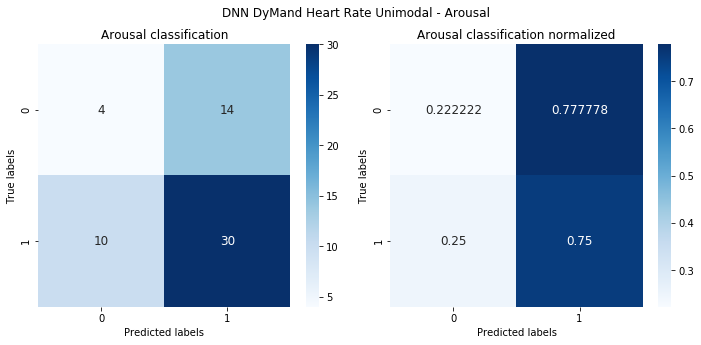

DNN validation score arousal with best hyperparameters -- Heart Rate Unimodal 0.4861111111111111


In [91]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_arousal_x
y_train = hr_arousal_y
X_test = hr_arousal_x_val
y_test = hr_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(416, input_dim=10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(160, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(114, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Heart Rate Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Heart Rate Unimodal", uar)

### Late Fusion: Valence -- HR

In [126]:
# hr_valence_x_all = hr_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary","PID"]))
# hr_valence_y_all = hr_unimodal_labels_merge_valence["Valence_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=5, random_state=4, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(hr_valence_x_all, hr_valence_y_all, hr_valence_groups)):
#     if folds == 1: 
#         hr_valence_x = hr_valence_x_all.iloc[train_idxs]
#         hr_valence_y = hr_valence_y_all.iloc[train_idxs]
#         hr_valence_x_val = hr_valence_x_all.iloc[test_idxs]
#         hr_valence_y_val = hr_valence_y_all.iloc[test_idxs]
        
#         hr_train_test_groups_valence = hr_valence_groups.iloc[train_idxs]
#         hr_val_groups_valence = hr_valence_groups.iloc[test_idxs]
        
#         hr_train_test_groups_valence_unique = np.unique(hr_valence_groups.iloc[train_idxs])
#         hr_val_groups_valence_unique = np.unique(hr_valence_groups.iloc[test_idxs])
        
# print(hr_valence_x.shape)
# print(hr_valence_x_val.shape)
# print("Train test groups: ", hr_train_test_groups_valence_unique)
# print("Validation groups: ", hr_val_groups_valence_unique)

In [51]:
hr_valence_x_all = hr_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary","PID","ID"]))
hr_valence_y_all = hr_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = sensor_merge_valence.loc[~sensor_merge_valence['ID'].isin(["004", "009"])].index.to_list()
test_idxs = sensor_merge_valence.loc[sensor_merge_valence['ID'].isin(["004", "009"])].index

hr_valence_x = hr_valence_x_all.loc[train_idxs]
hr_valence_y = hr_valence_y_all.loc[train_idxs]
hr_valence_x_val = hr_valence_x_all.loc[test_idxs]
hr_valence_y_val = hr_valence_y_all.loc[test_idxs]

hr_train_test_groups_valence = hr_valence_groups.loc[train_idxs]
hr_val_groups_valence = hr_valence_groups.loc[test_idxs]

hr_train_test_groups_valence_unique = np.unique(hr_valence_groups.loc[train_idxs])
hr_val_groups_valence_unique = np.unique(hr_valence_groups.loc[test_idxs])
        
print(hr_valence_x.shape)
print(hr_valence_x_val.shape)
print("Train test groups: ", hr_train_test_groups_valence_unique)
print("Validation groups: ", hr_val_groups_valence_unique)

(133, 10)
(62, 10)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [38]:
# Hyperparameter tuning SVM

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(hr_valence_x, hr_valence_y, groups=hr_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.6812857142857143
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear'}


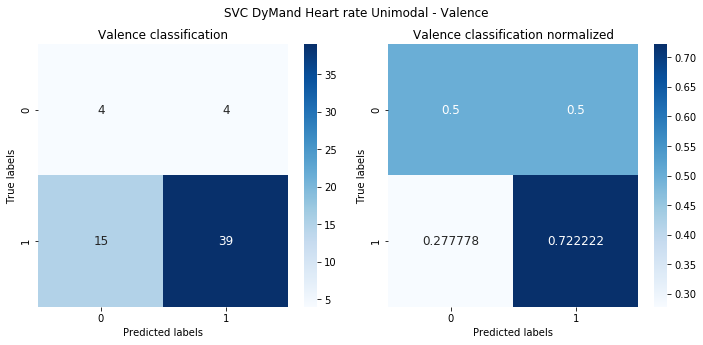

SVM validation Valence score with best hyperparameters - Heart rate Unimodal: 0.6111111111111112


In [74]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_valence_x
y_train = hr_valence_y
X_test = hr_valence_x_val
y_test = hr_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight="balanced", degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Heart rate Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Valence score with best hyperparameters - Heart rate Unimodal:", uar)

In [53]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(hr_valence_x, hr_valence_y, train_test_groups_valence)):
    if folds == 1: 
        hr_valence_x_train = hr_valence_x_all.iloc[train_idxs]
        hr_valence_y_train = hr_valence_y_all.iloc[train_idxs]
        hr_valence_x_test = hr_valence_x_all.iloc[test_idxs]
        hr_valence_y_test = hr_valence_y_all.iloc[test_idxs]
        
        hr_valence_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        hr_valence_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", hr_valence_x_train_groups)
print("Testing groups: ", hr_valence_x_test_groups)

Training groups:  ['003' '006' '007' '008' '012']
Testing groups:  ['010']


In [41]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_HR_Unimodal',
                     project_name='Trial3Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(hr_valence_x_train, hr_valence_y_train, epochs=100, validation_data=(hr_valence_x_test, hr_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6710526347160339
Total elapsed time: 00h 02m 07s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 448 
 Second layer: 96 
 Third layer: 64 
 
 Dropout 1: 0.5 
 Dropout 2: 0.0 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 1e-05.



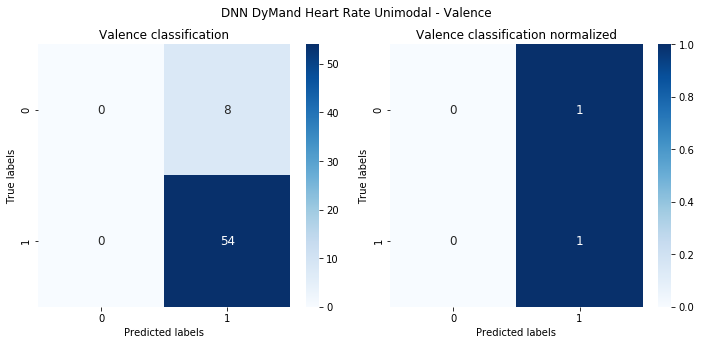

DNN validation score valence with best hyperparameters -- Heart Rate Unimodal 0.5


In [73]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = hr_valence_x
y_train = hr_valence_y
X_test = hr_valence_x_val
y_test = hr_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(448, input_dim=10, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(96, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Heart Rate Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Heart Rate Unimodal", uar)

### Late Fusion: Arousal -- ACC

In [134]:
# acc_arousal_x_all = acc_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID"]))
# acc_arousal_y_all = acc_unimodal_labels_merge_arousal["Arousal_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=5, random_state=1, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(acc_arousal_x_all, acc_arousal_y_all, acc_arousal_groups)):
#     if folds == 1: 
#         acc_arousal_x = acc_arousal_x_all.iloc[train_idxs]
#         acc_arousal_y = acc_arousal_y_all.iloc[train_idxs]
#         acc_arousal_x_val = acc_arousal_x_all.iloc[test_idxs]
#         acc_arousal_y_val = acc_arousal_y_all.iloc[test_idxs]
        
#         acc_train_test_groups_arousal = acc_arousal_groups.iloc[train_idxs]
#         acc_val_groups_arousal = acc_arousal_groups.iloc[test_idxs]
        
#         acc_train_test_groups_arousal_unique = np.unique(acc_arousal_groups.iloc[train_idxs])
#         acc_val_groups_arousal_unique = np.unique(acc_arousal_groups.iloc[test_idxs])
        
# print(acc_arousal_x.shape)
# print(acc_arousal_x_val.shape)
# print("Train test groups: ", acc_train_test_groups_arousal_unique)
# print("Validation groups: ", acc_val_groups_arousal_unique)

In [55]:
acc_arousal_x_all = acc_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
acc_arousal_y_all = acc_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = sensor_merge_arousal.loc[~sensor_merge_arousal['ID'].isin(["001", "006","010"])].index.to_list()
test_idxs = sensor_merge_arousal.loc[sensor_merge_arousal['ID'].isin(["001", "006","010"])].index

acc_arousal_x = acc_arousal_x_all.loc[train_idxs]
acc_arousal_y = acc_arousal_y_all.loc[train_idxs]
acc_arousal_x_val = acc_arousal_x_all.loc[test_idxs]
acc_arousal_y_val = acc_arousal_y_all.loc[test_idxs]

acc_train_test_groups_arousal = acc_arousal_groups.loc[train_idxs]
acc_val_groups_arousal = acc_arousal_groups.loc[test_idxs]

acc_train_test_groups_arousal_unique = np.unique(acc_arousal_groups.loc[train_idxs])
acc_val_groups_arousal_unique = np.unique(acc_arousal_groups.loc[test_idxs])
        
print(acc_arousal_x.shape)
print(acc_arousal_x_val.shape)
print("Train test groups: ", acc_train_test_groups_arousal_unique)
print("Validation groups: ", acc_val_groups_arousal_unique)

(235, 10)
(58, 10)
Train test groups:  ['003' '004' '005' '007' '008' '009' '012' '013']
Validation groups:  ['001' '006' '010']


In [45]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(acc_arousal_x, acc_arousal_y, groups=acc_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.6321684447147197
Best Hyperparameters: {'C': 1, 'class_weight': 'balanced', 'degree': 4, 'kernel': 'poly'}


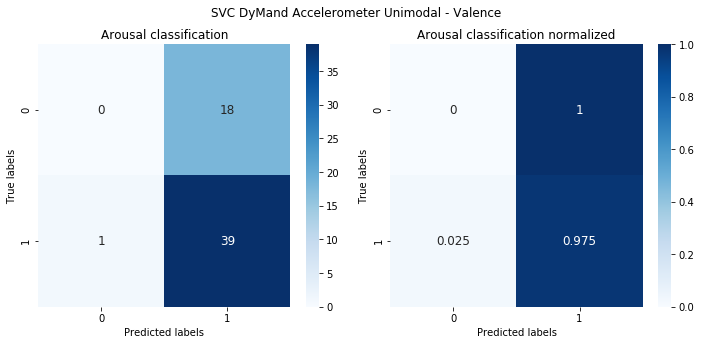

SVM validation Arousal score with best hyperparameters - Accelerometer Unimodal: 0.4875


In [72]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_arousal_x
y_train = acc_arousal_y
X_test = acc_arousal_x_val
y_test = acc_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight='balanced', degree=4, kernel="poly")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Accelerometer Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Accelerometer Unimodal:", uar)

In [41]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=4, random_state=1, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(acc_arousal_x, acc_arousal_y, train_test_groups_arousal)):
    if folds == 1: 
        acc_arousal_x_train = acc_arousal_x_all.iloc[train_idxs]
        acc_arousal_y_train = acc_arousal_y_all.iloc[train_idxs]
        acc_arousal_x_test = acc_arousal_x_all.iloc[test_idxs]
        acc_arousal_y_test = acc_arousal_y_all.iloc[test_idxs]
        
        acc_arousal_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        acc_arousal_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", acc_arousal_x_train_groups)
print("Testing groups: ", acc_arousal_x_test_groups)

Training groups:  ['003' '004' '005' '009' '012' '013']
Testing groups:  ['007' '008']


In [49]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_ACC_Unimodal',
                     project_name='Trial3Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(acc_arousal_x_train, acc_arousal_y_train, epochs=100, validation_data=(acc_arousal_x_test, acc_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5471928119659424

Best val_UAR_metric So Far: 0.6391468048095703
Total elapsed time: 00h 02m 07s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 272 
 Second layer: 352 
 Third layer: 32 
 
 Dropout 1: 0.5 
 Dropout 2: 0.4 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 1e-05.



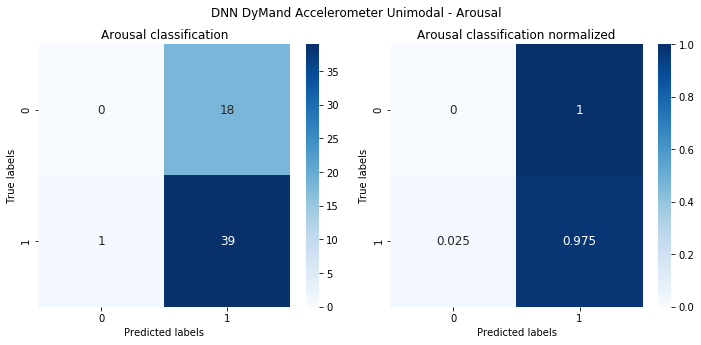

DNN validation score arousal with best hyperparameters -- Accelerometer Unimodal 0.4875


In [71]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_arousal_x
y_train = acc_arousal_y
X_test = acc_arousal_x_val
y_test = acc_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(272, input_dim=10, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(352, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Accelerometer Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Accelerometer Unimodal", uar)

## Late Fusion: Valence -- ACC

In [43]:
acc_valence_x_all = acc_unimodal_labels_merge_valence.drop(columns=(["Name","Valence_binary","PID","ID"]))
acc_valence_y_all = acc_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = sensor_merge_valence.loc[~sensor_merge_valence['ID'].isin(["004", "009"])].index.to_list()
test_idxs = sensor_merge_valence.loc[sensor_merge_valence['ID'].isin(["004", "009"])].index

acc_valence_x = acc_valence_x_all.loc[train_idxs]
acc_valence_y = acc_valence_y_all.loc[train_idxs]
acc_valence_x_val = acc_valence_x_all.loc[test_idxs]
acc_valence_y_val = acc_valence_y_all.loc[test_idxs]

acc_train_test_groups_valence = acc_valence_groups.loc[train_idxs]
acc_val_groups_valence = acc_valence_groups.loc[test_idxs]

acc_train_test_groups_valence_unique = np.unique(acc_valence_groups.loc[train_idxs])
acc_val_groups_valence_unique = np.unique(acc_valence_groups.loc[test_idxs])
        
print(acc_valence_x.shape)
print(acc_valence_x_val.shape)
print("Train test groups: ", acc_train_test_groups_valence_unique)
print("Validation groups: ", acc_val_groups_valence_unique)

(133, 10)
(62, 10)
Train test groups:  ['003' '006' '007' '008' '010' '012']
Validation groups:  ['004' '009']


In [52]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(acc_valence_x, acc_valence_y, groups=acc_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.5717619047619047
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}


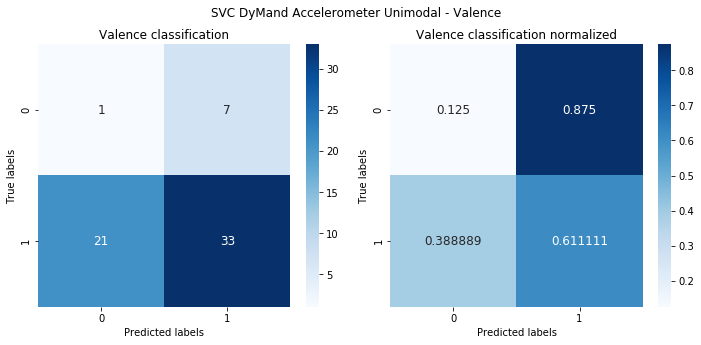

SVM validation Valence score with best hyperparameters - Accelerometer Unimodal: 0.3680555555555556


In [67]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_valence_x
y_train = acc_valence_y
X_test = acc_valence_x_val
y_test = acc_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight='balanced', degree=2, kernel="rbf")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC DyMand Accelerometer Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Valence score with best hyperparameters - Accelerometer Unimodal:", uar)

In [45]:
# Creating a train and test set for DNN hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(acc_valence_x, acc_valence_y, train_test_groups_valence)):
    if folds == 1: 
        acc_valence_x_train = acc_valence_x_all.iloc[train_idxs]
        acc_valence_y_train = acc_valence_y_all.iloc[train_idxs]
        acc_valence_x_test = acc_valence_x_all.iloc[test_idxs]
        acc_valence_y_test = acc_valence_y_all.iloc[test_idxs]
        
        acc_valence_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        acc_valence_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", acc_valence_x_train_groups)
print("Testing groups: ", acc_valence_x_test_groups)

Training groups:  ['003' '006' '007' '008' '012']
Testing groups:  ['010']


In [55]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=10, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='DyMand_ACC_Unimodal',
                     project_name='Trial3Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(acc_valence_x_train, acc_valence_y_train, epochs=100, validation_data=(acc_valence_x_test, acc_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 01s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.6907894611358643
Total elapsed time: 00h 02m 11s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 304 
 Second layer: 304 
 Third layer: 352 
 
 Dropout 1: 0.5 
 Dropout 2: 0.1 
 Dropout 3: 0.3 
 and the optimal learning rate for the optimizer
is 1e-05.



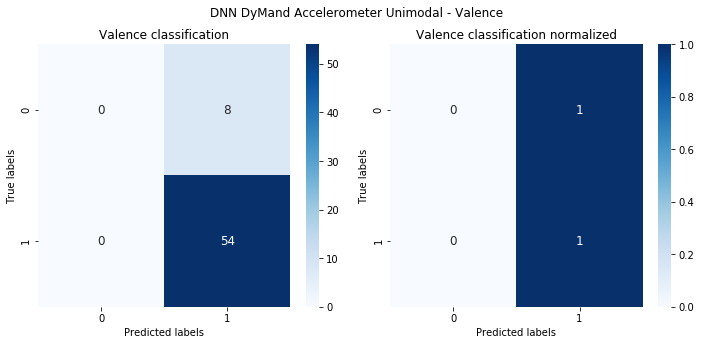

DNN Accelerometer Unimodal - Valence 0.5


In [65]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = acc_valence_x
y_train = acc_valence_y
X_test = acc_valence_x_val
y_test = acc_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting DNN
model = Sequential()
model.add(Dense(303, input_dim=10, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(304, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(352, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN DyMand Accelerometer Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN Accelerometer Unimodal - Valence", uar)

## Late fusion (HR and ACC) - Arousal

Late fusion averaging 0.5
Late fusion averaging prediction after converting predictions to binary 0.5152777777777777
Late fusion max of either input 0.5
Late fusion median 0.5


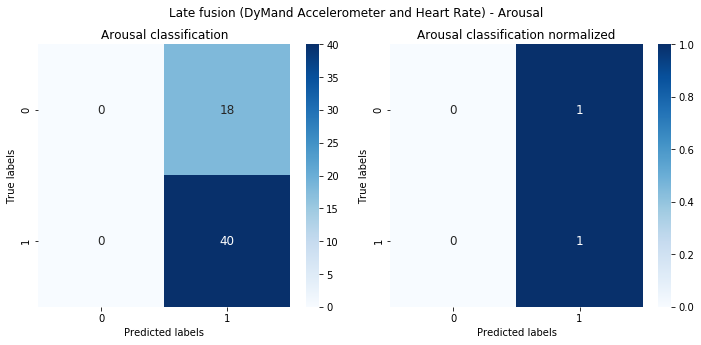

In [84]:
# Late fusion using averaging of predictions

# Find true values of arousal in validation set [001, 006, 010] that is common for both

if (hr_arousal_y_val.equals(acc_arousal_y_val)):
    hr_acc_y_val = acc_arousal_y_val # Should be the same as hr
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler hr
scaler_hr = StandardScaler()
hr_arousal_x_scaled = scaler.fit_transform(hr_arousal_x) # train
hr_arousal_x_val_scaled = scaler.transform(hr_arousal_x_val) #test 

# Best DNN for hr arousal
hr_unimodal_arousal = Sequential()
hr_unimodal_arousal.add(Dense(112, input_dim=10, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.5))
hr_unimodal_arousal.add(Dense(240, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.1))
hr_unimodal_arousal.add(Dense(208, activation="relu"))
hr_unimodal_arousal.add(Dropout(0.2))
hr_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
hr_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
hr_unimodal_arousal_y_pred = hr_unimodal_arousal.predict(hr_arousal_x_val_scaled, verbose=0)

# Best DNN for acc arousal

# StandardScaler acc
scaler_acc = StandardScaler()
acc_arousal_x_scaled = scaler.fit_transform(acc_arousal_x) # train
acc_arousal_x_val_scaled = scaler.transform(acc_arousal_x_val) #test 

acc_unimodal_arousal = Sequential()
acc_unimodal_arousal.add(Dense(448, input_dim=10, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.5))
acc_unimodal_arousal.add(Dense(96, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.0))
acc_unimodal_arousal.add(Dense(64, activation="relu"))
acc_unimodal_arousal.add(Dropout(0.1))
acc_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
acc_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
acc_unimodal_arousal_y_pred = acc_unimodal_arousal.predict(acc_arousal_x_val_scaled, verbose=0)

# Evaluate on 
hr_acc_pred_merge_arousal = np.array([hr_unimodal_arousal_y_pred,acc_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_arousal.mean(axis=0))
uar_late_fusion_hr_acc_pred_avg = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_avg)
print("Late fusion averaging", uar_late_fusion_hr_acc_pred_avg)

# Averaging prediction after converting predictions (baseline)
hr_acc_pred_merge_arousal_binary = np.array([np.rint(hr_unimodal_arousal_y_pred),np.rint(acc_unimodal_arousal_y_pred)])
late_fusion_hr_acc_pred_avg_binary = np.rint(hr_acc_pred_merge_arousal_binary.mean(axis=0))
uar_late_fusion_hr_acc_pred_binary= balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_hr_acc_pred_binary)

# Taking max prediction
late_fusion_hr_acc_pred_max = np.rint(hr_acc_pred_merge_arousal.max(axis=0))
uar_late_fusion_hr_acc_pred_max = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_max)
print("Late fusion max of either input", uar_late_fusion_hr_acc_pred_max)

# Taking median
late_fusion_hr_acc_pred_median = np.rint(np.median(hr_acc_pred_merge_arousal, axis=0))
uar_late_fusion_hr_acc_pred_median = balanced_accuracy_score(hr_arousal_y_val, late_fusion_hr_acc_pred_median)
print("Late fusion median", uar_late_fusion_hr_acc_pred_median)

cm = confusion_matrix(hr_arousal_y_val,late_fusion_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_arousal_y_val,late_fusion_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (DyMand Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [48]:
####### Transfer learning ########

# StandardScaler hr
scaler_hr = StandardScaler()
hr_arousal_x_scaled = scaler.fit_transform(hr_arousal_x) # train
hr_arousal_x_val_scaled = scaler.transform(hr_arousal_x_val) #test 

## Transfer learning hr 
print("Transfer learning hr arousal unimodal")

hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_hr_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 1e-05

#Freezing no layers
# for i in range(7):
#     hr_TL_model_arousal.layers[i].trainable = True


# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_arousal_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_hr_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    hr_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_arousal_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_hr_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    hr_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_arousal_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_hr_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    hr_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_arousal_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_hr_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    hr_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_arousal_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

print()

# Transfer learning acc 

# StandardScaler acc
scaler_acc = StandardScaler()
acc_arousal_x_scaled = scaler_acc.fit_transform(acc_arousal_x) # train
acc_arousal_x_val_scaled = scaler_acc.transform(acc_arousal_x_val) #test 

## Transfer learning acc 
print("Transfer learning acc arousal unimodal")

acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 1e-05

#Freezing no layers
# for i in range(7):
#     acc_TL_model_arousal.layers[i].trainable = True


# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_arousal_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    acc_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_arousal_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    acc_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_arousal_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    acc_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_arousal_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    acc_TL_model_arousal.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_arousal_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning hr arousal unimodal
Transfer learning after freezing 0 layers 0.5
Transfer learning after freezing 1 layer 0.5
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5027777777777778
Transfer learning after freezing 4 layers 0.5027777777777778

Transfer learning acc arousal unimodal
Transfer learning after freezing 0 layers 0.4875
Transfer learning after freezing 1 layer 0.4875
Transfer learning after freezing 2 layers 0.4875
Transfer learning after freezing 3 layers 0.4902777777777778
Transfer learning after freezing 4 layers 0.5055555555555555


Late fusion averaging arousal 0.5208333333333334


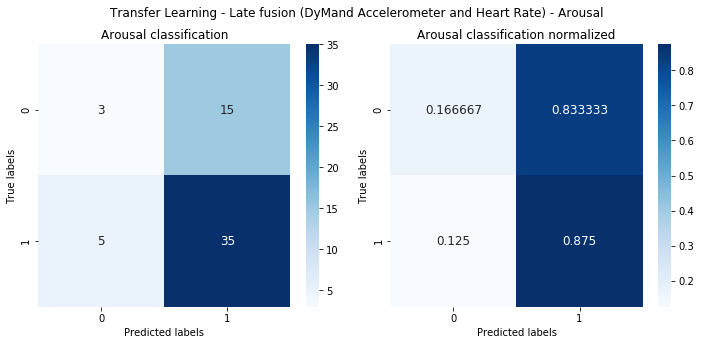

In [49]:
# Finding best results and use those for predictions

# Getting best results from hr arousal unimodal 

# Freezing layers all layers (including dropout)
hr_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    hr_TL_model_arousal.layers[i].trainable = False

# opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_arousal.compile(loss='binary_crossentropy', metrics=[UAR_metric])
# hr_TL_model_arousal.summary()
hr_TL_model_arousal.fit(hr_arousal_x_scaled, hr_arousal_y, epochs = 100, verbose=0)
# Prediction
hr_TL_unimodal_arousal_y_pred = hr_TL_model_arousal.predict(hr_arousal_x_val_scaled, verbose=0)
hr_TL_unimodal_arousal_y_pred = np.rint(hr_TL_unimodal_arousal_y_pred)


#####
# Freezing layers first layer (including dropout)
acc_TL_model_arousal = load_model("../K-EmoCon/KEmoCon_acc_latefusion_arousal.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    acc_TL_model_arousal.layers[i].trainable = False

# opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_arousal.compile(loss='binary_crossentropy', metrics=[UAR_metric])
# acc_TL_model_arousal.summary()
acc_TL_model_arousal.fit(acc_arousal_x_scaled, acc_arousal_y, epochs = 100, verbose=0)
# Prediction
acc_TL_unimodal_arousal_y_pred = acc_TL_model_arousal.predict(acc_arousal_x_val_scaled, verbose=0)
acc_TL_unimodal_arousal_y_pred = np.rint(acc_TL_unimodal_arousal_y_pred)

# Evaluate on 
hr_acc_pred_merge_arousal = np.array([hr_TL_unimodal_arousal_y_pred,acc_TL_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_TL_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_arousal.mean(axis=0))
uar_late_fusion_TL_hr_acc_pred_avg = balanced_accuracy_score(hr_arousal_y_val, late_fusion_TL_hr_acc_pred_avg)
print("Late fusion averaging arousal", uar_late_fusion_TL_hr_acc_pred_avg)

cm = confusion_matrix(hr_arousal_y_val,late_fusion_TL_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_arousal_y_val,late_fusion_TL_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Late fusion (DyMand Accelerometer and Heart Rate) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Late fusion (HR and ACC) - Valence

Late fusion averaging 0.5
Late fusion averaging prediction after converting predictions to binary 0.5
Late fusion max of either input 0.5
Late fusion median 0.5


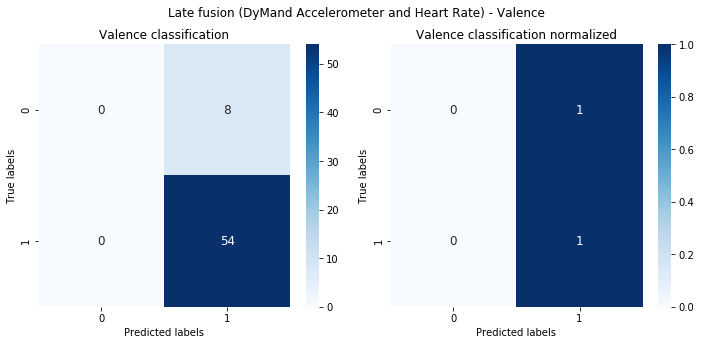

In [85]:
# Late fusion using averaging of predictions

# Find true values of valence in validation set [001, 006, 010] that is common for both

if (hr_valence_y_val.equals(acc_valence_y_val)):
    hr_acc_y_val = acc_valence_y_val # Should be the same as hr
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler hr
scaler_hr = StandardScaler()
hr_valence_x_scaled = scaler.fit_transform(hr_valence_x) # train
hr_valence_x_val_scaled = scaler.transform(hr_valence_x_val) #test 

# Best DNN for hr valence
hr_unimodal_valence = Sequential()
hr_unimodal_valence.add(Dense(272, input_dim=10, activation="relu"))
hr_unimodal_valence.add(Dropout(0.5))
hr_unimodal_valence.add(Dense(352, activation="relu"))
hr_unimodal_valence.add(Dropout(0.4))
hr_unimodal_valence.add(Dense(32, activation="relu"))
hr_unimodal_valence.add(Dropout(0.1))
hr_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
hr_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
hr_unimodal_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
hr_unimodal_valence_y_pred = hr_unimodal_valence.predict(hr_valence_x_val_scaled, verbose=0)

# Best DNN for acc valence

# StandardScaler acc
scaler_acc = StandardScaler()
acc_valence_x_scaled = scaler.fit_transform(acc_valence_x) # train
acc_valence_x_val_scaled = scaler.transform(acc_valence_x_val) #test 

acc_unimodal_valence = Sequential()
acc_unimodal_valence.add(Dense(304, input_dim=10, activation="relu"))
acc_unimodal_valence.add(Dropout(0.5))
acc_unimodal_valence.add(Dense(304, activation="relu"))
acc_unimodal_valence.add(Dropout(0.1))
acc_unimodal_valence.add(Dense(352, activation="relu"))
acc_unimodal_valence.add(Dropout(0.3))
acc_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-05)
acc_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
acc_unimodal_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
acc_unimodal_valence_y_pred = acc_unimodal_valence.predict(acc_valence_x_val_scaled, verbose=0)

# Evaluate on 
hr_acc_pred_merge_valence = np.array([hr_unimodal_valence_y_pred,acc_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_valence.mean(axis=0))
uar_late_fusion_hr_acc_pred_avg = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_avg)
print("Late fusion averaging", uar_late_fusion_hr_acc_pred_avg)

# Averaging prediction after converting predictions (baseline)
hr_acc_pred_merge_valence_binary = np.array([np.rint(hr_unimodal_valence_y_pred),np.rint(acc_unimodal_valence_y_pred)])
late_fusion_hr_acc_pred_avg_binary = np.rint(hr_acc_pred_merge_valence_binary.mean(axis=0))
uar_late_fusion_hr_acc_pred_binary= balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_hr_acc_pred_binary)

# Taking max prediction
late_fusion_hr_acc_pred_max = np.rint(hr_acc_pred_merge_valence.max(axis=0))
uar_late_fusion_hr_acc_pred_max = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_max)
print("Late fusion max of either input", uar_late_fusion_hr_acc_pred_max)

# Taking median
late_fusion_hr_acc_pred_median = np.rint(np.median(hr_acc_pred_merge_valence, axis=0))
uar_late_fusion_hr_acc_pred_median = balanced_accuracy_score(hr_valence_y_val, late_fusion_hr_acc_pred_median)
print("Late fusion median", uar_late_fusion_hr_acc_pred_median)

cm = confusion_matrix(hr_valence_y_val,late_fusion_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_valence_y_val,late_fusion_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (DyMand Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [59]:
####### Transfer learning ########

# StandardScaler hr
scaler_hr = StandardScaler()
hr_valence_x_scaled = scaler.fit_transform(hr_valence_x) # train
hr_valence_x_val_scaled = scaler.transform(hr_valence_x_val) #test 

## Transfer learning hr 
print("Transfer learning hr valence unimodal")

hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_hr_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.001

#Freezing no layers
# for i in range(7):
#     hr_TL_model_valence.layers[i].trainable = True


# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_valence_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_hr_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    hr_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_valence_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_hr_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    hr_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_valence_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_hr_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    hr_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_valence_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_hr_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    hr_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(hr_valence_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

print()

# Transfer learning acc 

# StandardScaler acc
scaler_acc = StandardScaler()
acc_valence_x_scaled = scaler_acc.fit_transform(acc_valence_x) # train
acc_valence_x_val_scaled = scaler_acc.transform(acc_valence_x_val) #test 

## Transfer learning acc 
print("Transfer learning acc valence unimodal")

acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})
model_LR = 0.001

#Freezing no layers
# for i in range(7):
#     acc_TL_model_valence.layers[i].trainable = True


# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_valence_y_val, y_pred)
print("Transfer learning after freezing 0 layers", uar)


# Freezing layers first layer (including dropout)
acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(2):
    acc_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_valence_y_val, y_pred)
print("Transfer learning after freezing 1 layer", uar)


# Freezing layers first 2 layers (including dropout)
acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    acc_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_valence_y_val, y_pred)
print("Transfer learning after freezing 2 layers", uar)


# Freezing layers first 3 layers (including dropout)
acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    acc_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_valence_y_val, y_pred)
print("Transfer learning after freezing 3 layers", uar)


# Freezing layers first 4 layers (including dropout)
acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(7):
    acc_TL_model_valence.layers[i].trainable = False

opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(acc_valence_y_val, y_pred)
print("Transfer learning after freezing 4 layers", uar)

Transfer learning hr valence unimodal
Transfer learning after freezing 0 layers 0.5
Transfer learning after freezing 1 layer 0.49074074074074076
Transfer learning after freezing 2 layers 0.49074074074074076
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.48842592592592593

Transfer learning acc valence unimodal
Transfer learning after freezing 0 layers 0.48148148148148145
Transfer learning after freezing 1 layer 0.4722222222222222
Transfer learning after freezing 2 layers 0.5
Transfer learning after freezing 3 layers 0.5
Transfer learning after freezing 4 layers 0.48148148148148145


Late fusion averaging valence 0.5


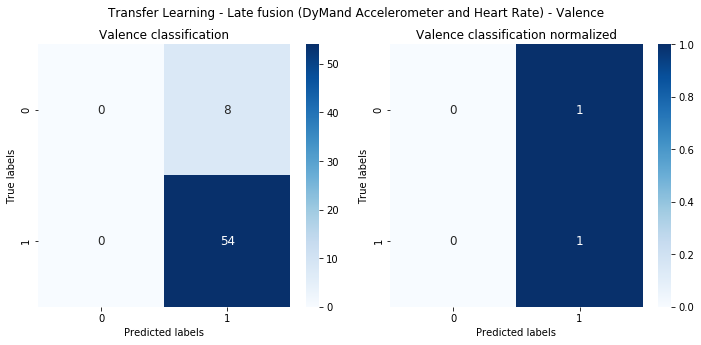

In [62]:
# Finding best results and use those for predictions

# Getting best results from hr valence unimodal 

# Freezing layers first 1 layers (including dropout)
hr_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(6):
    hr_TL_model_valence.layers[i].trainable = False

# opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
hr_TL_model_valence.compile(loss='binary_crossentropy', metrics=[UAR_metric])
# hr_TL_model_valence.summary()
hr_TL_model_valence.fit(hr_valence_x_scaled, hr_valence_y, epochs = 100, verbose=0)
# Prediction
hr_TL_unimodal_valence_y_pred = hr_TL_model_valence.predict(hr_valence_x_val_scaled, verbose=0)
hr_TL_unimodal_valence_y_pred = np.rint(hr_TL_unimodal_valence_y_pred)


#####
# Freezing layers third layer (including dropout)
acc_TL_model_valence = load_model("../K-EmoCon/KEmoCon_acc_latefusion_valence.h5",custom_objects={"UAR_metric": UAR_metric})

for i in range(4):
    acc_TL_model_valence.layers[i].trainable = False

# opt = keras.optimizers.Adam(learning_rate=model_LR) # LR from pre-trained model
acc_TL_model_valence.compile(loss='binary_crossentropy', metrics=[UAR_metric])
# acc_TL_model_valence.summary()
acc_TL_model_valence.fit(acc_valence_x_scaled, acc_valence_y, epochs = 100, verbose=0)
# Prediction
acc_TL_unimodal_valence_y_pred = acc_TL_model_valence.predict(acc_valence_x_val_scaled, verbose=0)
acc_TL_unimodal_valence_y_pred = np.rint(acc_TL_unimodal_valence_y_pred)

# Evaluate on 
hr_acc_pred_merge_valence = np.array([hr_TL_unimodal_valence_y_pred,acc_TL_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_TL_hr_acc_pred_avg = np.rint(hr_acc_pred_merge_valence.mean(axis=0))
uar_late_fusion_TL_hr_acc_pred_avg = balanced_accuracy_score(hr_valence_y_val, late_fusion_TL_hr_acc_pred_avg)
print("Late fusion averaging valence", uar_late_fusion_TL_hr_acc_pred_avg)

cm = confusion_matrix(hr_valence_y_val,late_fusion_TL_hr_acc_pred_avg)
cm_normalized = confusion_matrix(hr_valence_y_val,late_fusion_TL_hr_acc_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Transfer Learning - Late fusion (DyMand Accelerometer and Heart Rate) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()